# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from newsapi import NewsApiClient

%matplotlib inline
load_dotenv()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jhg55\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Read your api key environment variable
api_key = os.getenv("news_api")

In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [4]:
def read_all_about_it(subject:str):
    news = newsapi.get_everything(
        q=subject,
        language="en"
    )
    return pd.DataFrame.from_dict(news['articles'])[['title','author','description','content','publishedAt']]

In [5]:
# Fetch the Bitcoin news articles
# Create the Bitcoin sentiment scores DataFrame
bitcoin_news = read_all_about_it("Bitcoin")

In [6]:
# Fetch the Ethereum news articles
# Create the Ethereum sentiment scores DataFrame
ethereum_news = read_all_about_it("Ethereum")

In [7]:
def extract_vader(text,tag=None):
    """
    Extracts Vader scores from a text. Option to tag data
    """
    scores = {}
    sentiment_text = analyzer.polarity_scores(text)
    scores[f'{f"{tag}_" if tag != None else ""}compound'] = sentiment_text['compound']
    scores[f'{f"{tag}_" if tag != None else ""}pos'] = sentiment_text['pos']
    scores[f'{f"{tag}_" if tag != None else ""}neu'] = sentiment_text['neu']
    scores[f'{f"{tag}_" if tag != None else ""}neg'] = sentiment_text['neg']
    return scores

In [8]:
def vader_all_about_it(news:pd.DataFrame,target='content'):
    """
    Collects vader scores on a given DataFrame, views only a specific column (default 'content')
    """
    vader_list = []
    for text in news[target]:
        vader_list.append(extract_vader(text))
    return pd.DataFrame(vader_list)

In [9]:
# Describe the Bitcoin Sentiment
vader_bitcoin = vader_all_about_it(bitcoin_news)
vader_bitcoin.describe()

,compound,pos,neu,neg
count,20.000000,20.000000,20.00000,20.000000
mean,-0.013850,0.058600,0.88780,0.053600
std,0.401941,0.063568,0.06748,0.044219
min,-0.542300,0.000000,0.77200,0.000000
25%,-0.350550,0.000000,0.84250,0.000000
50%,-0.064000,0.050500,0.90400,0.065500
75%,0.196075,0.084250,0.92725,0.081250
max,0.735100,0.197000,1.00000,0.143000


In [10]:
# Describe the Ethereum Sentiment
vader_ethereum = vader_all_about_it(ethereum_news)
vader_ethereum.describe()

,compound,pos,neu,neg
count,20.000000,20.000000,20.000000,20.000000
mean,-0.007765,0.077300,0.856950,0.065700
std,0.480410,0.102811,0.113815,0.070344
min,-0.784500,0.000000,0.594000,0.000000
25%,-0.278900,0.000000,0.809750,0.000000
50%,-0.127900,0.054000,0.868500,0.063000
75%,0.303775,0.085000,0.937000,0.086750
max,0.932700,0.349000,1.000000,0.233000


### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum

Q: Which coin had the highest compound score?

A: Ethereum

Q. Which coin had the highest positive score?

A: Ethereum

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [11]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [12]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
extra_sw = 'reuters'
sw = sw.union(extra_sw)

In [13]:
# Complete the tokenizer function
def tokenizer(text:str):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    text_clean = regex.sub('', text)
   
    # Create a tokenized list of the words
    tokenized = word_tokenize(text_clean)
    
    # Lemmatize words into root words
    lemmatized = [lemmatizer.lemmatize(token) for token in tokenized]
   
    # Convert the words to lowercase and Remove the stop words
    tokens = [token.lower() for token in lemmatized if token.lower() not in sw]
    
    return tokens

In [14]:
def token_column(df:pd.DataFrame, column:str):
    df[f'tokens_{column}'] = [tokenizer(col) for col in df[column]]
    return df

In [15]:
# Create a new tokens column for Bitcoin
token_column(bitcoin_news,'title')
token_column(bitcoin_news,'description')
token_column(bitcoin_news,'content')
bitcoin_news.head()

,title,author,description,content,publishedAt,tokens_title,tokens_description,tokens_content
0,Block and Blockstream are partnering with Tesl...,Jay Peters,Block and Blockstream are partnering with Tesl...,Its set to open later this year\r\nIf you buy ...,2022-04-08T16:02:52Z,"[block, blockstream, partnering, tesla, offgri...","[block, blockstream, partnering, tesla, openso...","[set, open, later, yearif, buy, something, ver..."
1,Wikipedia editors vote to block cryptocurrency...,Mariella Moon,Wikipedia editors have voted in favor of dropp...,Wikipedia editors have voted in favor of dropp...,2022-04-14T11:35:49Z,"[wikipedia, editor, vote, block, cryptocurrenc...","[wikipedia, editor, voted, favor, dropping, cr...","[wikipedia, editor, voted, favor, dropping, cr..."
2,Warren Buffett Says He Wouldn't Take All the B...,Matt Novak,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02T11:30:00Z,"[warren, buffett, says, wouldnt, take, bitcoin...","[warren, buffett, ha, always, bitcoin, skeptic...","[warren, buffett, ha, always, bitcoin, skeptic..."
3,What Twitter Is Really Planning for Crypto,Gian M. Volpicelli,The duo behind Twitter Crypto say NFT profile ...,"You might have heard of crypto Twitter, the co...",2022-04-05T11:00:00Z,"[twitter, really, planning, crypto]","[duo, behind, twitter, crypto, say, nft, profi...","[might, heard, crypto, twitter, corner, social..."
4,This might be Jack Dorsey’s ‘rockey’ hardware ...,Mitchell Clark,"The hardware lead for Block, formerly Square, ...",The wallet will have USB-C and a fingerprint r...,2022-04-06T17:30:19Z,"[might, jack, dorseys, rockey, hardware, crypt...","[hardware, lead, block, formerly, square, ha, ...","[wallet, usbc, fingerprint, reader, image, jes..."


In [16]:
# Create a new tokens column for Ethereum
token_column(ethereum_news,'title')
token_column(ethereum_news,'description')
token_column(ethereum_news,'content')
ethereum_news.head()

,title,author,description,content,publishedAt,tokens_title,tokens_description,tokens_content
0,US blames North Korean hacker group for $625 m...,Emma Roth,The US Department of Treasury has attributed t...,The US Department of Treasury says Lazarus is ...,2022-04-14T21:43:57Z,"[us, blame, north, korean, hacker, group, mill...","[us, department, treasury, ha, attributed, axi...","[us, department, treasury, say, lazarus, behin..."
1,Wikipedia community votes to stop accepting cr...,Timothy B. Lee,Critics argue the bitcoin and ethereum network...,"18 with 15 posters participating, including st...",2022-04-13T16:35:03Z,"[wikipedia, community, vote, stop, accepting, ...","[critics, argue, bitcoin, ethereum, network, c...","[poster, participating, including, story, auth..."
2,"Blockchains Have a ‘Bridge’ Problem, and Hacke...",Lily Hay Newman,Blockchain bridges are a crucial piece of the ...,"This week, the cryptocurrency network Ronin di...",2022-04-03T11:00:00Z,"[blockchains, bridge, problem, hackers, know]","[blockchain, bridge, crucial, piece, cryptocur...","[week, cryptocurrency, network, ronin, disclos..."
3,Opera's crypto browser is now available on iOS,Mariella Moon,"Opera launched its dedicated ""Crypto Browser"" ...","Opera launched its dedicated ""Crypto Browser"" ...",2022-04-15T11:37:13Z,"[operas, crypto, browser, available, ios]","[opera, launched, dedicated, crypto, browser, ...","[opera, launched, dedicated, crypto, browser, ..."
4,Yuga Labs apologises after sale of virtual lan...,Alex Hern,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02T15:54:35Z,"[yuga, labs, apologises, sale, virtual, land, ...","[demand, plot, land, multiplayer, game, others...","[multibillion, dollar, cryptocurrency, company..."


---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [17]:
from collections import Counter
from nltk import ngrams

In [18]:
# Generate the Bitcoin N-grams where N=2
# YOUR CODE HERE!

In [19]:
# Generate the Ethereum N-grams where N=2
# YOUR CODE HERE!

In [20]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [21]:
# Use token_count to get the top 10 words for Bitcoin
# YOUR CODE HERE!

In [22]:
# Use token_count to get the top 10 words for Ethereum
# YOUR CODE HERE!

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [24]:
def gen_wc(df:pd.DataFrame, column:str):
    output = ' '
    all_tokens = []
    for tokens in bitcoin_news['tokens_title']:
        all_tokens += tokens
    output = output.join(all_tokens)
    return WordCloud().generate(output)

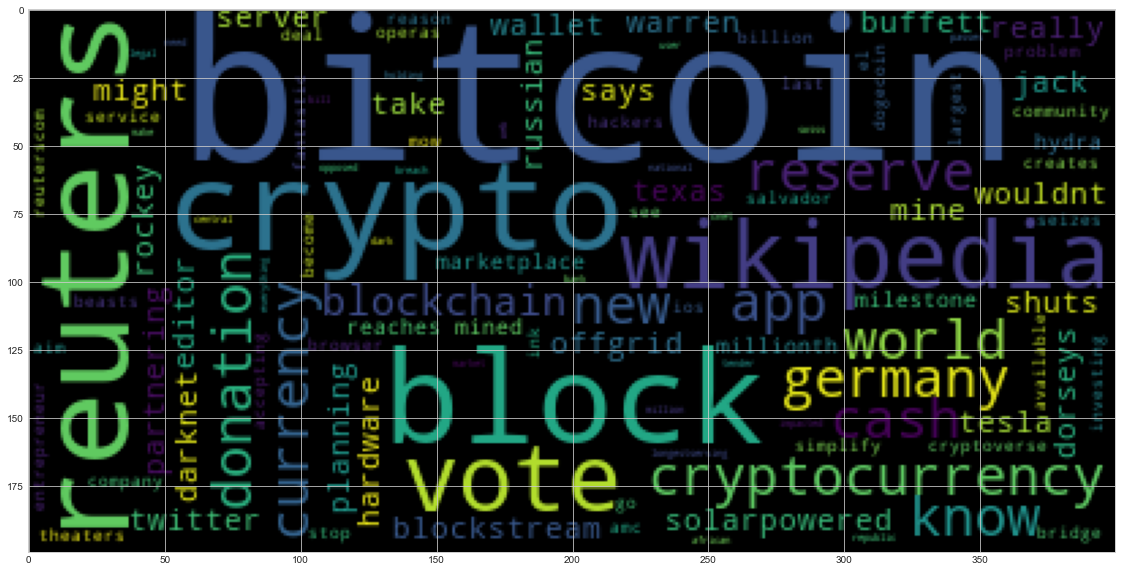

In [25]:
# Generate the Bitcoin word cloud
bitcoin_wc = gen_wc(bitcoin_news, 'tokens_content')
plt.imshow(bitcoin_wc)

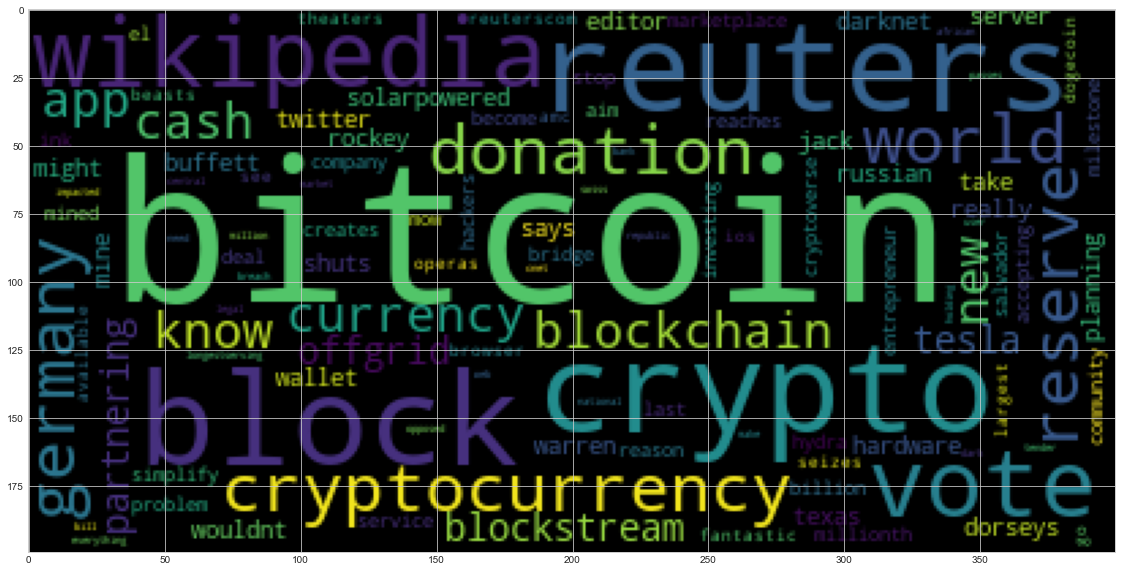

In [26]:
# Generate the Ethereum word cloud
ethereum_wc = gen_wc(ethereum_news, 'tokens_content')
plt.imshow(ethereum_wc)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [24]:
import spacy
from spacy import displacy

In [25]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [26]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [27]:
# Concatenate all of the Bitcoin text together
# YOUR CODE HERE!

In [28]:
# Run the NER processor on all of the text
# YOUR CODE HERE!

# Add a title to the document
# YOUR CODE HERE!

In [29]:
# Render the visualization
# YOUR CODE HERE!

In [30]:
# List all Entities
# YOUR CODE HERE!

---

### Ethereum NER

In [31]:
# Concatenate all of the Ethereum text together
# YOUR CODE HERE!

In [32]:
# Run the NER processor on all of the text
# YOUR CODE HERE!

# Add a title to the document
# YOUR CODE HERE!

In [33]:
# Render the visualization
# YOUR CODE HERE!

In [34]:
# List all Entities
# YOUR CODE HERE!

---